In [1]:
import pandas as pd
import torch
import sys
import matplotlib.pyplot as plt


sys.path.append("../../../")
from ae_architectures.lstm import LSTMAutoEncoder
from src.dataset import ExerciseDataset

## Load data and model

In [2]:
NUM_JOINTS = 15
SEQUENCE_LENGTH = 25
LATENT_SIZE = 256
NUM_LAYERS = 2
HIDDEN_SIZE = 256

In [26]:
dct_lstm_autoencoder = LSTMAutoEncoder(
    SEQUENCE_LENGTH, NUM_JOINTS * 3, HIDDEN_SIZE, LATENT_SIZE, NUM_LAYERS
)
dct_lstm_autoencoder.load_state_dict(
    torch.load(
        "../../../models/squat_dct_lstm.pt", map_location=torch.device("cpu")
    )
)

<All keys matched successfully>

In [27]:
squat_dct_df = pd.read_csv("../../../data/train/dct/squat.csv")
squat_dct_dataset = ExerciseDataset(squat_dct_df, representation="dct")

## Generation of the embedded instances

In [32]:
from sklearn.preprocessing import LabelEncoder
import numpy as np

X = torch.stack([rep for rep in squat_dct_dataset.data])
y = np.array(
    [
        1 if label == 0 else 0
        for label in squat_dct_dataset.labels_encoded
    ]
)
X_embedded = dct_lstm_autoencoder.encoder(X).detach().numpy()

In [35]:
from torch.utils.data import DataLoader

train_squat_dct_dl = DataLoader(
    squat_dct_dataset,
    batch_size=8,
    shuffle=True,
)

In [47]:
torch.stack([rep for rep in train_squat_dct_dl.dataset.data])


tensor([[[ 6.3857e-03,  2.6333e-01,  2.0629e+00,  ...,  4.2318e-01,
           5.8996e-01, -1.4256e+00],
         [ 1.8464e-02,  3.8602e-02, -2.3428e-02,  ..., -9.8149e-03,
          -1.9894e-02,  2.9604e-02],
         [ 1.0405e-02,  1.2536e-01, -5.6878e-02,  ...,  3.0537e-02,
          -4.3346e-01, -6.0154e-01],
         ...,
         [ 6.0111e-05,  2.7236e-04, -2.8002e-04,  ...,  1.4553e-04,
          -4.7243e-04, -5.0759e-05],
         [ 1.5804e-04,  7.8071e-05, -1.4549e-04,  ..., -2.5791e-04,
          -9.0752e-05,  3.2068e-05],
         [-2.0806e-05,  2.8783e-04, -2.7150e-04,  ...,  8.9100e-05,
          -5.3893e-04,  1.4465e-05]],

        [[ 7.3773e-02,  2.9166e-01,  2.0891e+00,  ...,  7.2945e-01,
           3.5415e-01, -1.5261e+00],
         [ 5.5269e-02,  3.4588e-02, -2.1599e-02,  ..., -2.4236e-03,
          -2.9180e-02, -5.1776e-02],
         [ 2.4434e-02,  1.1807e-01, -5.5254e-02,  ..., -1.3656e-02,
          -3.3931e-01, -5.4330e-01],
         ...,
         [ 2.5159e-04,  1

In [33]:
X_embedded

array([[ 0.10465042, -0.01060601, -0.39248753, ..., -0.11087663,
        -0.43728587, -0.03658785],
       [ 0.00480048,  0.19550791, -0.0223812 , ...,  0.12411972,
        -0.25751737,  0.02883292],
       [ 0.06569014, -0.00994423, -0.26969236, ..., -0.15671247,
         0.31287187,  0.04209179],
       ...,
       [-0.0366945 ,  0.006141  , -0.1459345 , ..., -0.03801617,
        -0.32263976,  0.03941533],
       [-0.00619465,  0.02027   , -0.16029689, ..., -0.04405211,
        -0.29289085,  0.07245515],
       [ 0.0229802 , -0.01452392, -0.22364971, ..., -0.08497304,
        -0.2635757 ,  0.06084841]], dtype=float32)

## Visualization of the latent space

/Users/hubert/Github-Repositories/explainable-methods-in-exercise-analysis/.env/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/hubert/Github-Repositories/explainable-methods-in-exercise-analysis/.env/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


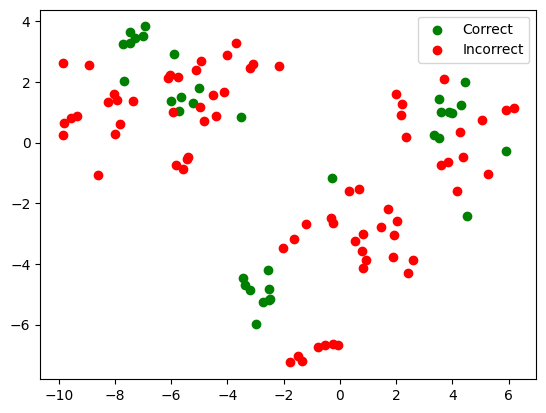

In [6]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
X_embedded_reduced = tsne.fit_transform(X_embedded)
plt.scatter(X_embedded_reduced[y == 1][:, 0], X_embedded_reduced[y == 1][:, 1], c="green")
plt.scatter(X_embedded_reduced[y == 0][:, 0], X_embedded_reduced[y == 0][:, 1], c="red")

plt.legend(["Correct", "Incorrect"])

## Training of the classifier

In [7]:
squat_dct_test_df = pd.read_csv("../../../data/test/dct/squat.csv")
squat_dct_dataset_test = ExerciseDataset(squat_dct_test_df, representation="dct")

In [8]:
X_test = torch.stack([rep for rep in squat_dct_dataset_test.data])
y_test = np.array(
    [
        1 if label == 0 else 0
        for label in squat_dct_dataset_test.labels_encoded
    ]
)
X_test_embedded = dct_lstm_autoencoder.encoder(X_test).detach().numpy()

In [9]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split


clf = DecisionTreeClassifier().fit(X_embedded, y)
y_pred = clf.predict(X_test_embedded)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.94      0.89        18
           1       0.80      0.57      0.67         7

    accuracy                           0.84        25
   macro avg       0.82      0.76      0.78        25
weighted avg       0.84      0.84      0.83        25



## Generate CFE

In [10]:
y

array([1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [11]:
train_df = pd.DataFrame(X_embedded)
train_df = train_df.rename(str, axis="columns")
features = list(train_df.columns)

train_df["label"] = y

In [12]:
print(y)

[1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0
 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0
 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [13]:
import dice_ml

m = dice_ml.Model(model=clf, backend='sklearn')
d = dice_ml.Data(dataframe=train_df, continuous_features=features, outcome_name='label')
exp = dice_ml.Dice(d, m)

In [18]:
test_df = pd.DataFrame(X_embedded)
test_df = test_df.rename(str, axis="columns")

explaination = exp.generate_counterfactuals(test_df.iloc[[1]], total_CFs=1, desired_class="opposite")
explaination.visualize_as_dataframe(show_only_changes=True)

  0%|          | 0/1 [00:00<?, ?it/s]/Users/hubert/Github-Repositories/explainable-methods-in-exercise-analysis/.env/lib/python3.11/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/Users/hubert/Github-Repositories/explainable-methods-in-exercise-analysis/.env/lib/python3.11/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/Users/hubert/Github-Repositories/explainable-methods-in-exercise-analysis/.env/lib/python3.11/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/Users/hubert/Github-Repositories/explainable-methods-in-exercise-analysis/.env/lib/python3.11/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(

Query instance (original outcome : 0)


,0,1,2,3,4,5,6,7,8,9,...,247,248,249,250,251,252,253,254,255,label
0,0.0048,0.195508,-0.022381,-0.228017,0.631739,0.632251,0.058275,0.2104,0.03141,-0.061718,...,-0.311584,0.081714,-0.395064,0.575817,0.112507,0.898687,0.12412,-0.257517,0.028833,0



Diverse Counterfactual set (new outcome: 1)


,0,1,2,3,4,5,6,7,8,9,...,247,248,249,250,251,252,253,254,255,label
0,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,1.0


## Decode generated CFE to DCT

In [15]:
cf_instance = torch.tensor(explaination.cf_examples_list[0].final_cfs_df.values[:, :-1]).float()

decoded_cf_dct = dct_lstm_autoencoder.decoder(cf_instance)

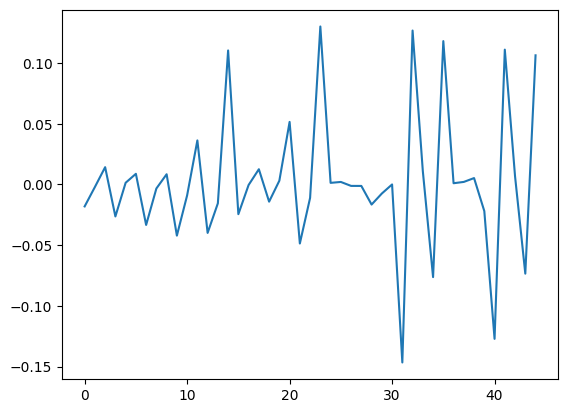

In [16]:
plt.plot(decoded_cf_dct.detach().numpy().squeeze()[4]);

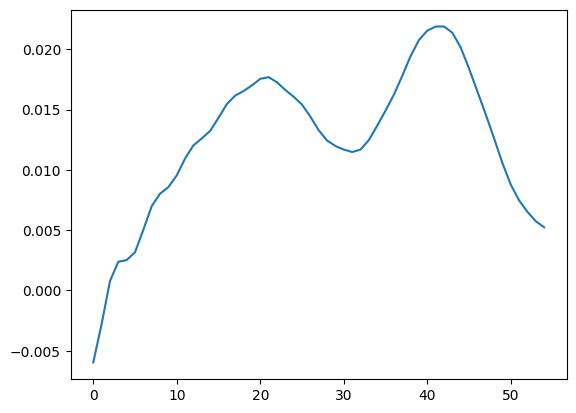

In [17]:
from scipy.fft import idct

new_signal = decoded_cf_dct.squeeze().detach().numpy()[:, 3]
x_dct = np.zeros(55, dtype=float)
x_dct[:25] = new_signal
new_signal = idct(x_dct, norm="ortho")

plt.plot(new_signal)